# 调试主函数

此文件是本项目的主函数，请依次运行单元格。


In [1]:
import numpy as np
from model import ThreeLayerNN, visualize_weights, ReLU, save_model_weights, load_model_weights
from training import SGD, LRScheduler, train_and_evaluate, plot_training_history
from data_handling import load_mnist_images, load_mnist_labels, download, batch_generator, split_train_val
from testing import test

c:\Users\heyh0\.conda\envs\deeplearning39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\heyh0\.conda\envs\deeplearning39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\heyh0\.conda\envs\deeplearning39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 数据读取
下载数据集，若数据集已存在则不重复下载。

In [2]:
# URLs for the train image and label data
url_base = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
train_images_filename = 'train-images-idx3-ubyte.gz'
train_labels_filename = 'train-labels-idx1-ubyte.gz'
test_images_filename = 't10k-images-idx3-ubyte.gz'
test_labels_filename = 't10k-labels-idx1-ubyte.gz'

# 下载数据集
download(url_base + train_images_filename, train_images_filename)
download(url_base + train_labels_filename, train_labels_filename)
download(url_base + test_images_filename, test_images_filename)
download(url_base + test_labels_filename, test_labels_filename)

# 数据预处理
预处理数据，在原有的训练集中划出一部分作为验证集。将数据整理成适合迭代的小批量。

In [3]:
# 加载和预处理数据集
x_train, y_train = load_mnist_images(train_images_filename), load_mnist_labels(train_labels_filename)
x_test, y_test = load_mnist_images(test_images_filename), load_mnist_labels(test_labels_filename)

# 划分训练集和验证集
x_train, y_train, x_val, y_val = split_train_val(x_train, y_train, val_fraction=0.1)

# 创建训练和验证数据加载器
train_loader = batch_generator(x_train, y_train, batch_size=64)
val_loader = batch_generator(x_val, y_val, batch_size=64)

# 由于测试集不需要计算梯度，可以将整个测试集作为一个批次进行处理
test_loader = batch_generator(x_test, y_test, batch_size=None, shuffle=False)

print("Data shapes:", "Train:", x_train.shape, y_train.shape, "Val:", x_val.shape, y_val.shape, "Test:", x_test.shape, y_test.shape)


Data shapes: Train: (54000, 784) (54000, 10) Val: (6000, 784) (6000, 10) Test: (10000, 784) (10000, 10)


# 超参数遍历调优
以下是调参函数。此函数根据输入的超参数列表依次训练模型，根据验证集上的准确率保存最优的超参数。

In [4]:
# 调参函数
def hyperparameter_search(X_train, Y_train, X_val, Y_val, learning_rates, hidden_layer_sizes, weight_decays):
    best_accuracy = -np.inf
    best_params = None
    best_history = None

    for lr in learning_rates:
        for hidden_size in hidden_layer_sizes:
            for weight_decay in weight_decays:
                print(f"Training with lr={lr}, hidden_size={hidden_size}, weight_decay={weight_decay}")
                model = ThreeLayerNN(input_dim=784, hidden_dim1=hidden_size, hidden_dim2=hidden_size//2, output_dim=10, activation_fn=ReLU)
                optimizer = SGD(model, lr=lr, weight_decay=weight_decay)
                scheduler = LRScheduler(optimizer, decay_rate=1, step_size=5)

                history = train_and_evaluate(model, X_train, Y_train, X_val, Y_val, optimizer, scheduler, epochs=10)

                val_accuracy = history['val_accuracy'][-1]
                train_accuracy = history['train_accuracy'][-1]  # 获取训练集最后一个epoch的准确率
                print(f"Epoch 10, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

                # 选择更好的准确率指标，可以是验证准确率或训练准确率
                # overall_best_accuracy = max(train_accuracy, val_accuracy)
                overall_best_accuracy = val_accuracy
                if overall_best_accuracy > best_accuracy:
                    best_accuracy = overall_best_accuracy
                    best_params = {'lr': lr, 'hidden_size': hidden_size, 'weight_decay': weight_decay}
                    best_history = history

    print(f"Best parameters: {best_params}, Best accuracy: {best_accuracy}")
    return best_params, best_history


In [5]:
# 定义一组要测试的超参数
learning_rates = [0.00075, 0.001, 0.00125 ]
hidden_layer_sizes = [512]
weight_decays = [0, 0.2, 0.4]

# 超参数搜索和训练
best_params, best_history = hyperparameter_search(x_train, y_train, x_val, y_val, learning_rates, hidden_layer_sizes, weight_decays)


Training with lr=0.00075, hidden_size=512, weight_decay=0
Epoch 1, Train Loss: 0.5865, Val Loss: 0.4853, Val Accuracy: 0.8285
Epoch 2, Train Loss: 0.4217, Val Loss: 0.4197, Val Accuracy: 0.8517
Epoch 3, Train Loss: 0.3766, Val Loss: 0.4006, Val Accuracy: 0.8527
Epoch 4, Train Loss: 0.3483, Val Loss: 0.3656, Val Accuracy: 0.8728
Epoch 5, Train Loss: 0.3288, Val Loss: 0.3585, Val Accuracy: 0.8725
Epoch 6, Train Loss: 0.3122, Val Loss: 0.3363, Val Accuracy: 0.8822
Epoch 7, Train Loss: 0.2978, Val Loss: 0.3212, Val Accuracy: 0.8883
Epoch 8, Train Loss: 0.2862, Val Loss: 0.3309, Val Accuracy: 0.8857
Epoch 9, Train Loss: 0.2747, Val Loss: 0.3491, Val Accuracy: 0.8767
Epoch 10, Train Loss: 0.2644, Val Loss: 0.3212, Val Accuracy: 0.8855
Epoch 10, Train Accuracy: 0.9022, Val Accuracy: 0.8855
Training with lr=0.00075, hidden_size=512, weight_decay=0.2
Epoch 1, Train Loss: 0.6076, Val Loss: 0.4745, Val Accuracy: 0.8348
Epoch 2, Train Loss: 0.4465, Val Loss: 0.4216, Val Accuracy: 0.8507
Epoch 3, T

# 可视化
根据调参得到的参数重新训练模型。将此模型的参数可视化，并可视化训练全过程。

In [6]:
# 重新训练最佳模型
model = ThreeLayerNN(input_dim=784, hidden_dim1=best_params['hidden_size'], hidden_dim2=best_params['hidden_size']//2, output_dim=10, activation_fn=ReLU)
optimizer = SGD(model, lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = LRScheduler(optimizer, decay_rate=1, step_size=5)
history = train_and_evaluate(model, x_train, y_train, x_val, y_val, optimizer, scheduler, epochs=10)
save_model_weights(model, 'model_weights.npz')

Epoch 1, Train Loss: 0.5702, Val Loss: 0.4519, Val Accuracy: 0.8395
Epoch 2, Train Loss: 0.4096, Val Loss: 0.3853, Val Accuracy: 0.8653
Epoch 3, Train Loss: 0.3648, Val Loss: 0.3953, Val Accuracy: 0.8573
Epoch 4, Train Loss: 0.3378, Val Loss: 0.3672, Val Accuracy: 0.8693
Epoch 5, Train Loss: 0.3177, Val Loss: 0.3440, Val Accuracy: 0.8830
Epoch 6, Train Loss: 0.3007, Val Loss: 0.3284, Val Accuracy: 0.8837
Epoch 7, Train Loss: 0.2881, Val Loss: 0.3277, Val Accuracy: 0.8830
Epoch 8, Train Loss: 0.2757, Val Loss: 0.3419, Val Accuracy: 0.8775
Epoch 9, Train Loss: 0.2652, Val Loss: 0.3442, Val Accuracy: 0.8777
Epoch 10, Train Loss: 0.2555, Val Loss: 0.3068, Val Accuracy: 0.8950
Model weights saved to model_weights.npz


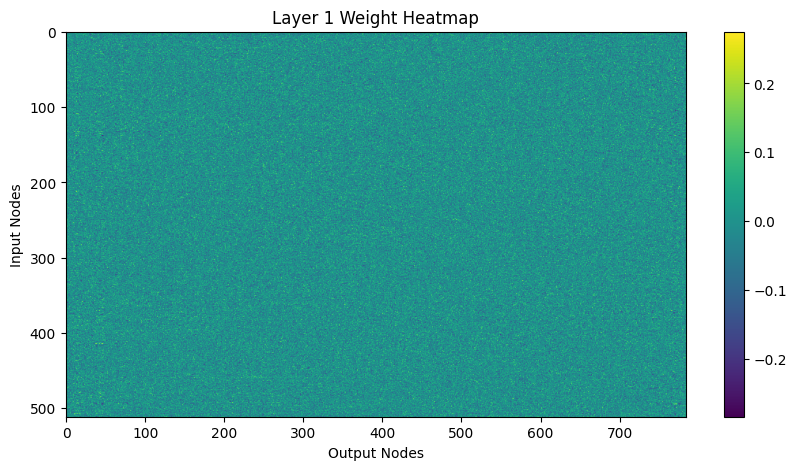

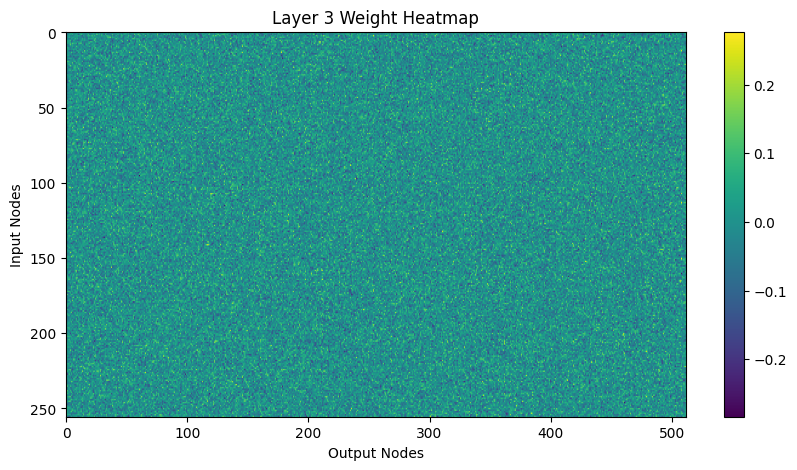

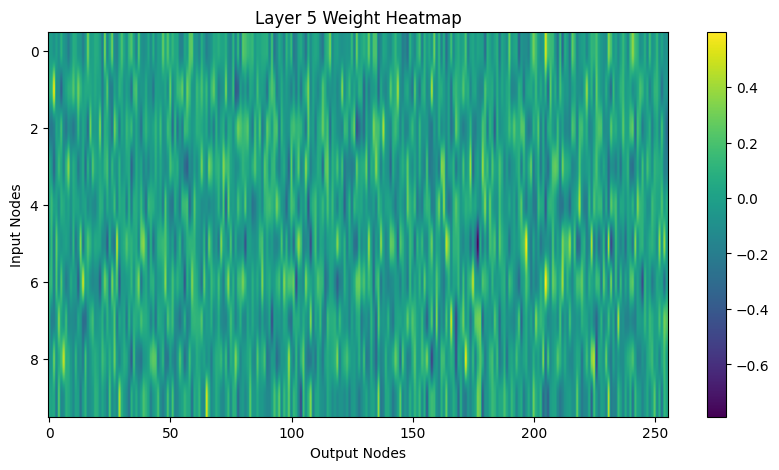

In [7]:
# 可视化最佳模型的参数
visualize_weights(model)

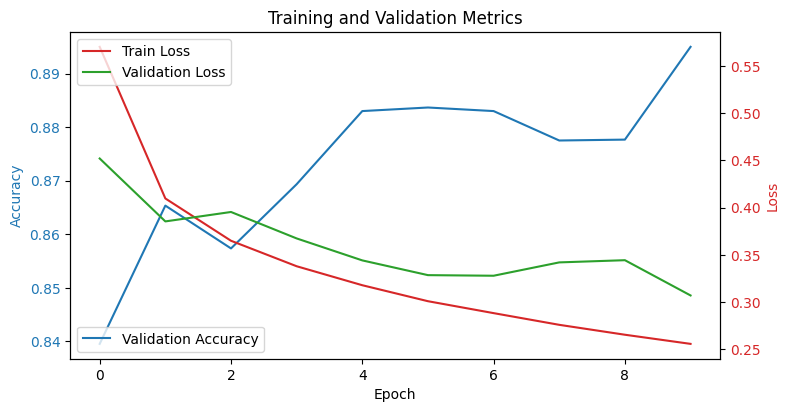

In [8]:
# 可视化最优参数训练过程的性能指标变化

plot_training_history(history)

# 最终测试
在测试集上做最终检测，检查泛化性能。

In [9]:
test_loader = batch_generator(x_test, y_test, batch_size=None, shuffle=False)
model_test = ThreeLayerNN(input_dim=784, hidden_dim1=best_params['hidden_size'], hidden_dim2=best_params['hidden_size']//2, output_dim=10, activation_fn=ReLU)
load_model_weights(model_test, 'model_weights.npz')

test_accuracy = test(model_test, test_loader)
print(f"Test accuracy: {test_accuracy:.4f}")

Model weights loaded from model_weights.npz
Test accuracy: 0.8846
